# 实验四：PCA+LDA (Fisherface) 人脸识别

## 实验原理

### 线性判别分析 (LDA) 概述
LDA是一种监督学习的降维算法，与PCA不同，LDA充分利用类标签信息，寻找最大化类间距离、最小化类内距离的投影方向，从而实现更好的分类性能。

本实验采用**PCA预降维 + LDA**的两阶段方法，先通过PCA降低维度到合理范围，再在PCA空间中进行LDA，以提高数值稳定性和计算效率。

### 核心思想
- 第一阶段（PCA）：无监督降维，从 d 维降至 (n-c) 维，其中n为样本数，c为类别数
- 第二阶段（LDA）：有监督降维，利用类别标签信息，进一步降至 c-1 维
- 最大化类间散度，最小化类内散度
- 找到最优的判别方向进行数据投影
- 在低维空间中保持最佳的类别可分性

## 数学原理

### 第一步：PCA预降维

#### 1.1 数据中心化
给定训练数据矩阵 $X \in \mathbb{R}^{n \times d}$ 和对应标签 $y$，其中 $n$ 为样本数，$d$ 为原始特征维度，$c$ 为类别数。

对数据进行中心化：
$$X_{centered} = X - \mu, \quad \mu = \frac{1}{n}\sum_{i=1}^{n}x_i \in \mathbb{R}^d$$

#### 1.2 SVD分解与投影矩阵计算
对中心化的数据进行奇异值分解（SVD）：
$$X_{centered} = U \Sigma V^T$$

其中：
- $U \in \mathbb{R}^{n \times n}$：左奇异向量
- $\Sigma \in \mathbb{R}^{n \times d}$：奇异值矩阵
- $V \in \mathbb{R}^{d \times d}$：右奇异向量

取前 $k = n - c$ 个右奇异向量构成PCA投影矩阵：
$$W_{pca} = V_{:,1:k} \in \mathbb{R}^{d \times (n-c)}$$

其中 $n-c$ 为PCA降维后的维度。

#### 1.3 数据投影到PCA空间
$$X_{pca} = X_{centered} \cdot W_{pca} \in \mathbb{R}^{n \times (n-c)}$$

### 第二步：在PCA空间中计算LDA

#### 2.1 计算均值向量（PCA空间）
在PCA空间中计算全局均值：
$$\mu_{pca} = \frac{1}{n}\sum_{i=1}^{n}x_{pca,i}$$

各类均值向量（对于第 $j$ 类）：
$$\mu_{j,pca} = \frac{1}{n_j}\sum_{i: y_i=j}x_{pca,i}$$

其中 $n_j$ 为第 $j$ 类的样本数量。

#### 2.2 计算类内散度矩阵（PCA空间）
在PCA空间中计算类内散度矩阵，衡量各类内部数据的离散程度：
$$S_w = \sum_{j=1}^{c}\sum_{i: y_i=j} (x_{pca,i} - \mu_{j,pca})(x_{pca,i} - \mu_{j,pca})^T \in \mathbb{R}^{(n-c) \times (n-c)}$$

物理意义：
- 描述每个类别内部样本相对于类中心的散布情况
- $S_w$ 越小，说明类内聚集度越高

#### 2.3 计算类间散度矩阵（PCA空间）
在PCA空间中计算类间散度矩阵，衡量不同类别中心之间的分离程度：
$$S_b = \sum_{j=1}^{c}n_j(\mu_{j,pca} - \mu_{pca})(\mu_{j,pca} - \mu_{pca})^T \in \mathbb{R}^{(n-c) \times (n-c)}$$

物理意义：
- 描述各类中心相对于全局中心的散布情况
- $S_b$ 越大，说明类间分离度越高

### 第三步：求解广义特征值问题

LDA的目标是找到投影方向 $w$，使得投影后的数据满足：
$$J(w) = \frac{w^T S_b w}{w^T S_w w}$$

这等价于求解广义特征值问题：
$$S_w^{-1}S_b w = \lambda w$$

其中：
- $\lambda$ 为广义特征值
- $w$ 为对应的特征向量（LDA判别方向）

在PCA空间中，$w \in \mathbb{R}^{n-c}$

### 第四步：选择最优判别方向

按特征值从大到小排序，选择前 $k$ 个最大特征值对应的特征向量：
$$W_{lda} = [w_1, w_2, \ldots, w_k] \in \mathbb{R}^{(n-c) \times k}$$

其中 $k = \min(c-1, n-c)$（最多 $c-1$ 个有效判别方向）。

### 第五步：计算最终投影矩阵

最终的投影矩阵由PCA和LDA的复合得到：
$$W_{final} = W_{pca} \cdot W_{lda} \in \mathbb{R}^{d \times k}$$

这样可以直接将原始数据投影到最终的LDA空间，而无需中间步骤。

### 第六步：数据投影

将原始数据投影到最终的LDA判别空间：
$$Y = X \cdot W_{final} \in \mathbb{R}^{n \times k}$$

其中 $k$ 为最终的判别向量个数（通常为 $c-1$）。

### 分类阶段

使用最近邻分类器进行分类：

对于测试样本 $x_{test}$，计算其在LDA空间中到所有训练样本的距离：
$$d_i = \|y_{test} - y_{train,i}\|_2$$

选择距离最小的训练样本对应的标签作为预测结果：
$$\hat{y} = y_{train[argmin(d_i)]}$$

## 算法流程总结

| 步骤 | 操作 | 输入维度 | 输出维度 | 说明 |
|------|------|---------|---------|------|
| 1 | 数据中心化 | $d$ | $d$ | 减去全局均值 |
| 2 | SVD分解 | $d$ | $d$ | 计算右奇异向量 |
| 3 | PCA投影 | $d$ | $n-c$ | 取前n-c个主成分 |
| 4 | 计算S_w, S_b | $n-c$ | $n-c$ | 在PCA空间中计算散度矩阵 |
| 5 | 广义特征值分解 | $n-c$ | $c-1$ | 求解 $S_w^{-1}S_b w = \lambda w$ |
| 6 | 矩阵复合 | $d$ | $c-1$ | $W_{final} = W_{pca} \cdot W_{lda}$ |
| 7 | 数据投影 | $d$ | $c-1$ | $Y = X \cdot W_{final}$ |

## 算法优势

### PCA预降维的作用
1. **数值稳定性**：从10304维直接做LDA会导致矩阵条件数极大，使用PCA先降到280维能显著改善
2. **计算效率**：降低矩阵运算的复杂度，从 $O(d^3)$ 降至 $O((n-c)^3)$
3. **避免奇异性**：PCA空间的维度 $(n-c)$ 小于样本数 $n$，避免S_w矩阵奇异

### LDA的优势（vs PCA）
| 特征 | PCA | LDA |
|------|-----|-----|
| 学习类型 | 无监督 | 有监督 |
| 目标函数 | 最大化方差 | 最大化类间散度/类内散度比 |
| 利用信息 | 仅数据分布 | 数据分布 + 类标签 |
| 最大维度 | $\min(n, d)$ | $c-1$（类别数-1） |
| 适用场景 | 数据压缩、可视化 | 分类任务 |
| 判别能力 | 一般 | 强 |

## 实验参数

- **原始维度** $d$ = 112 × 92 = 10304
- **样本数** $n$ = 320
- **类别数** $c$ = 40
- **PCA降维后维度** = $n - c$ = 320 - 40 = 280
- **最终特征维度** = $c - 1$ = 40 - 1 = 39
- **总体维度压缩比** = 39/10304 ≈ 0.38%
- **分类器** = 最近邻分类器（k=1）

In [33]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib
import time

matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

print("="*70)
print("LDA (Fisherface) 算法对ORL人脸数据集的训练与评估")
print("="*70)

LDA (Fisherface) 算法对ORL人脸数据集的训练与评估


In [34]:
ORL_FACE_DIR = "./ORL"

def load_images_from_folder(folder):
    """加载ORL数据集
    
    数据集结构：
    ./ORL/
    ├── s1/ (人物1)
    │   ├── 1.pgm
    │   ├── 2.pgm
    │   └── ...
    ├── s2/ (人物2)
    └── ...
    
    数据集信息：
    - 40个人物，每人10张图像
    - 图像大小：112×92像素
    - 总计：400张灰度图像
    """
    images = []
    labels = []
    label_map = {}
    current_label = 0
    
    sub_folders = sorted(os.listdir(folder))
    for sub_folder in sub_folders:
        sub_folder_path = os.path.join(folder, sub_folder)
        if os.path.isdir(sub_folder_path):
            label_map[current_label] = sub_folder
            img_files = sorted(os.listdir(sub_folder_path))
            for filename in img_files:
                img_path = os.path.join(sub_folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(current_label)
            current_label += 1
    
    return np.array(images), np.array(labels), label_map

print("\n[步骤1] 加载ORL人脸数据集...")
images, labels, label_map = load_images_from_folder(ORL_FACE_DIR)
print(f"已加载 {len(images)} 张图像，共 {len(label_map)} 个人物")
print(f"图像尺寸: {images[0].shape} (高×宽)")
print(f"类别数: {len(np.unique(labels))}")
h, w = images[0].shape


[步骤1] 加载ORL人脸数据集...
已加载 400 张图像，共 40 个人物
图像尺寸: (112, 92) (高×宽)
类别数: 40


In [35]:
print("\n[步骤2] 数据预处理 - 图像展平")
print("将二维图像展平为一维向量：")
print(f"   原始形状：{h} × {w} = {h*w} 维")
print(f"   操作：X = [img1.flatten(), img2.flatten(), ...]")

X = np.array([img.flatten() for img in images]).astype(np.float32)
print(f"\n特征矩阵X的形状: {X.shape}")
print(f"   行数 (样本数): {X.shape[0]}")
print(f"   列数 (原始特征维度): {X.shape[1]}")

print("\n[步骤3] 数据集分割")
print("按8:2比例分割为训练集和测试集")
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"训练集大小: {X_train.shape[0]} 样本 × {X_train.shape[1]} 维特征")
print(f"测试集大小: {X_test.shape[0]} 样本 × {X_test.shape[1]} 维特征")
print(f"训练集中类别数: {len(np.unique(y_train))}")
print(f"测试集中类别数: {len(np.unique(y_test))}")


[步骤2] 数据预处理 - 图像展平
将二维图像展平为一维向量：
   原始形状：112 × 92 = 10304 维
   操作：X = [img1.flatten(), img2.flatten(), ...]

特征矩阵X的形状: (400, 10304)
   行数 (样本数): 400
   列数 (原始特征维度): 10304

[步骤3] 数据集分割
按8:2比例分割为训练集和测试集
训练集大小: 320 样本 × 10304 维特征
测试集大小: 80 样本 × 10304 维特征
训练集中类别数: 40
测试集中类别数: 40


In [36]:
class LDAClassifier:
    """LDA (Fisherface) 分类器实现 - 使用PCA预降维

    算法流程：
    1. PCA预降维：维度 = n_samples - n_classes，得到W_pca和X_pca
    2. 在PCA空间计算散度矩阵：使用X_pca计算S_w和S_b
    3. 求解广义特征值问题：S_w^{-1}S_b w = λw，得到W_lda
    4. 最终投影矩阵：W_final = W_pca @ W_lda
    5. 投影数据：Y = X @ W_final
    6. 分类：使用最近邻分类器
    """

    def __init__(self, num_components=39):
        self.num_components = num_components  # 最终判别向量个数
        self.pca_dim = None                   # PCA降维后维度
        self.W_pca = None                     # PCA投影矩阵
        self.pca_mean = None                  # PCA均值
        self.W_lda = None                     # LDA判别向量矩阵
        self.components = None                # 最终投影矩阵 W_final = W_pca @ W_lda
        self.explained_variance = None        # LDA特征值
        self.train_features = None            # 投影后的训练特征
        self.train_labels = None              # 训练标签
        self.train_time = 0                   # 训练时间
        self.S_w = None                       # 类内散度矩阵（PCA空间）
        self.S_b = None                       # 类间散度矩阵（PCA空间）

    def _pca_reduce(self, X, y):
        """PCA预降维

        维度：pca_dim = n_samples - n_classes
        方法：SVD分解
        返回：W_pca, X_pca
        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.pca_dim = n_samples - n_classes

        print("\n4.1 PCA预降维")
        print(f"    原始维度: {n_features}")
        print(f"    目标维度: {self.pca_dim} (n_samples={n_samples} - n_classes={n_classes})")

        # 中心化
        self.pca_mean = np.mean(X, axis=0)
        X_centered = X - self.pca_mean

        # SVD分解
        print("    使用SVD分解计算PCA投影矩阵")
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # 取前pca_dim个奇异向量作为PCA投影矩阵
        self.W_pca = Vt[:self.pca_dim, :].T.astype(np.float32)  # shape: (n_features, pca_dim)

        # 投影到PCA空间
        X_pca = X_centered @ self.W_pca  # shape: (n_samples, pca_dim)

        print(f"    W_pca形状: {self.W_pca.shape}")
        print(f"    X_pca形状: {X_pca.shape}")
        print(f"    维度压缩: {n_features} → {self.pca_dim}")

        return X_pca

    def fit(self, X, y):
        """训练LDA模型（在PCA空间中）"""
        start_time = time.time()

        print("\n[步骤4] LDA训练 (PCA + LDA)")

        # 步骤1：PCA预降维
        X_pca = self._pca_reduce(X, y)

        # 步骤2-3：在PCA空间计算散度矩阵
        print("\n4.2 在PCA空间计算散度矩阵")

        unique_classes = np.unique(y)
        class_means_pca = {}
        n_samples_per_class = {}

        # 全局均值（PCA空间）
        mean_pca = np.mean(X_pca, axis=0)

        # 各类均值（PCA空间）
        for cls in unique_classes:
            X_cls_pca = X_pca[y == cls]
            class_means_pca[cls] = np.mean(X_cls_pca, axis=0)
            n_samples_per_class[cls] = len(X_cls_pca)

        print(f"    全局均值: μ in R^{mean_pca.shape[0]}")
        print(f"    类别数: {len(unique_classes)}")

        # 计算类内散度矩阵 S_w (PCA空间)
        print("    计算类内散度矩阵 S_w")
        d_pca = X_pca.shape[1]
        self.S_w = np.zeros((d_pca, d_pca), dtype=np.float64)

        for cls in unique_classes:
            X_cls_pca = X_pca[y == cls]
            mu_cls_pca = class_means_pca[cls]
            for x in X_cls_pca:
                diff = (x - mu_cls_pca).reshape(-1, 1)
                self.S_w += diff @ diff.T

        print(f"    S_w形状: {self.S_w.shape}")
        print(f"    S_w条件数: {np.linalg.cond(self.S_w):.2e}")

        # 计算类间散度矩阵 S_b (PCA空间)
        print("    计算类间散度矩阵 S_b")
        self.S_b = np.zeros((d_pca, d_pca), dtype=np.float64)

        for cls in unique_classes:
            n_j = n_samples_per_class[cls]
            mu_j_pca = class_means_pca[cls]
            diff = (mu_j_pca - mean_pca).reshape(-1, 1)
            self.S_b += n_j * (diff @ diff.T)

        print(f"    S_b形状: {self.S_b.shape}")
        print(f"    S_b秩: {np.linalg.matrix_rank(self.S_b)}")

        # 步骤4：求解广义特征值问题
        print("\n4.3 求解广义特征值问题 (PCA空间)")
        print("    求解: S_w^{-1}S_b w = λw")

        try:
            S_w_inv = np.linalg.inv(self.S_w)
            print("    S_w可逆")
        except np.linalg.LinAlgError:
            print("    警告: S_w奇异，使用伪逆")
            S_w_inv = np.linalg.pinv(self.S_w)

        M = S_w_inv @ self.S_b
        eig_vals, eig_vecs = np.linalg.eig(M)

        # 按特征值从大到小排序
        idx = np.argsort(-eig_vals.real)[:self.num_components]
        self.W_lda = eig_vecs[:, idx].real.astype(np.float32)  # shape: (pca_dim, num_components)
        self.explained_variance = eig_vals[idx].real

        print(f"    前5个特征值: {self.explained_variance[:5]}")
        print(f"    选择判别向量数: {len(idx)}")
        print(f"    W_lda形状: {self.W_lda.shape}")

        # 步骤5：计算最终投影矩阵
        print("\n4.4 计算最终投影矩阵")
        print("    W_final = W_pca @ W_lda")
        self.components = (self.W_pca @ self.W_lda).astype(np.float32)
        print(f"    W_final形状: {self.components.shape}")

        # 步骤6：投影训练数据到最终空间
        print("\n4.5 投影到最终LDA空间")
        self.train_features = X @ self.components  # 直接用原始X投影
        self.train_labels = y
        print(f"    投影后特征: Y in R^({self.train_features.shape[0]} × {self.train_features.shape[1]})")

        self.train_time = time.time() - start_time

        # 计算累积判别贡献率
        cumsum_var = np.cumsum(self.explained_variance) / np.sum(self.explained_variance) if np.sum(self.explained_variance) > 0 else np.ones_like(self.explained_variance)

        print(f"\n{'='*70}")
        print(f"{'LDA训练完成':^70}")
        print(f"{'='*70}")
        print(f"训练耗时: {self.train_time:.4f} 秒")
        print(f"原始特征维度: {X.shape[1]} 维")
        print(f"PCA降维后维度: {self.pca_dim} 维")
        print(f"最终特征维度: {self.num_components} 维")
        print(f"总体维度压缩比: {self.num_components / X.shape[1]:.6f}")
        print(f"累积判别贡献率: {cumsum_var[-1]:.6f}")
        print(f"最大可能判别向量数: {len(unique_classes) - 1}")
        print(f"{'='*70}\n")

    def transform(self, X):
        """投影新数据到最终LDA空间

        计算：Y = X @ W_final
        """
        return X @ self.components

    def predict(self, X):
        """使用最近邻分类器进行预测

        对于每个测试样本x_test：
        1. 投影到LDA空间：y_test = x_test @ W_final
        2. 计算距离：d_i = ||y_test - y_train_i||_2
        3. 找最近邻：i_min = argmin(d_i)
        4. 预测标签：y_pred = y_train[i_min]
        """
        X_transformed = self.transform(X)
        predictions = []

        for x in X_transformed:
            distances = np.linalg.norm(self.train_features - x, axis=1)
            nearest_idx = np.argmin(distances)
            predictions.append(self.train_labels[nearest_idx])

        return np.array(predictions)

print("LDA分类器已定义\n")
lda_clf = LDAClassifier(num_components=39)  # 最大为类别数-1=40-1=39
lda_clf.fit(X_train, y_train)

LDA分类器已定义


[步骤4] LDA训练 (PCA + LDA)

4.1 PCA预降维
    原始维度: 10304
    目标维度: 280 (n_samples=320 - n_classes=40)
    使用SVD分解计算PCA投影矩阵
    W_pca形状: (10304, 280)
    X_pca形状: (320, 280)
    维度压缩: 10304 → 280

4.2 在PCA空间计算散度矩阵
    全局均值: μ in R^280
    类别数: 40
    计算类内散度矩阵 S_w
    S_w形状: (280, 280)
    S_w条件数: 1.74e+07
    计算类间散度矩阵 S_b
    S_b形状: (280, 280)
    S_b秩: 279

4.3 求解广义特征值问题 (PCA空间)
    求解: S_w^{-1}S_b w = λw
    S_w可逆
    前5个特征值: [1306758.52710435   53177.75321533   18931.43202121   12222.39821879
    4475.96577102]
    选择判别向量数: 39
    W_lda形状: (280, 39)

4.4 计算最终投影矩阵
    W_final = W_pca @ W_lda
    W_final形状: (10304, 39)

4.5 投影到最终LDA空间
    投影后特征: Y in R^(320 × 39)

                               LDA训练完成                                
训练耗时: 0.9281 秒
原始特征维度: 10304 维
PCA降维后维度: 280 维
最终特征维度: 39 维
总体维度压缩比: 0.003785
累积判别贡献率: 1.000000
最大可能判别向量数: 39



In [37]:
print("[步骤5] 特征提取")
print(f"已将训练集数据投影到{lda_clf.num_components}维LDA空间")
print(f"已将测试集数据投影到{lda_clf.num_components}维LDA空间")

print("\n[步骤6] 分类预测")
print("在测试集上进行预测...")
y_pred = lda_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*70}")
print(f"{'LDA分类器评估结果':^70}")
print(f"{'='*70}")
print(f"测试准确率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"正确分类: {int(np.sum(y_pred == y_test))} / {len(y_test)}")
print(f"错误分类: {int(np.sum(y_pred != y_test))} / {len(y_test)}")
print(f"{'='*70}\n")

[步骤5] 特征提取
已将训练集数据投影到39维LDA空间
已将测试集数据投影到39维LDA空间

[步骤6] 分类预测
在测试集上进行预测...

                              LDA分类器评估结果                              
测试准确率: 0.9500 (95.00%)
正确分类: 76 / 80
错误分类: 4 / 80



In [38]:
print("[步骤7] 性能评估\n")
print("分类报告 (精度、召回率、F1分数)")
print("="*70)
print(classification_report(y_test, y_pred, digits=4))

[步骤7] 性能评估

分类报告 (精度、召回率、F1分数)
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         2
           3     1.0000    1.0000    1.0000         2
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         2
           6     1.0000    1.0000    1.0000         2
           7     1.0000    1.0000    1.0000         2
           8     0.6667    1.0000    0.8000         2
           9     1.0000    1.0000    1.0000         2
          10     1.0000    1.0000    1.0000         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    1.0000    1.0000         2
          13     1.0000    1.0000    1.0000         2
          14     1.0000    1.0000    1.0000         2
          15     1.0000    1.0000    1.0000         2
          16     0.6667    1.0000    0.8000       


[步骤8] 结果可视化

绘制混淆矩阵...


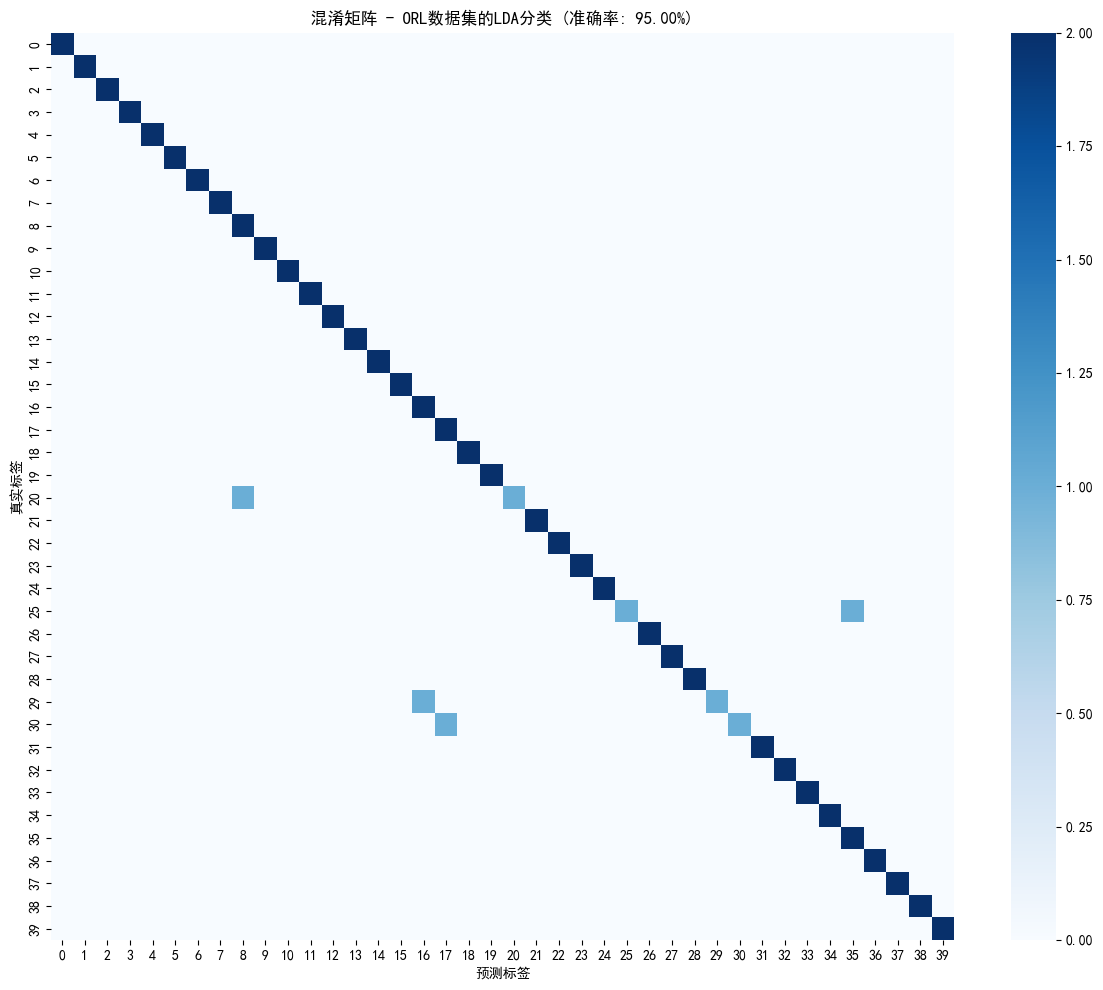

In [39]:
print("\n[步骤8] 结果可视化\n")
print("绘制混淆矩阵...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title(f'混淆矩阵 - ORL数据集的LDA分类 (准确率: {accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()

显示前12个Fisherface...
Fisherface是LDA判别向量在原始图像空间中的表现
每个Fisherface代表一个最优的类别判别方向



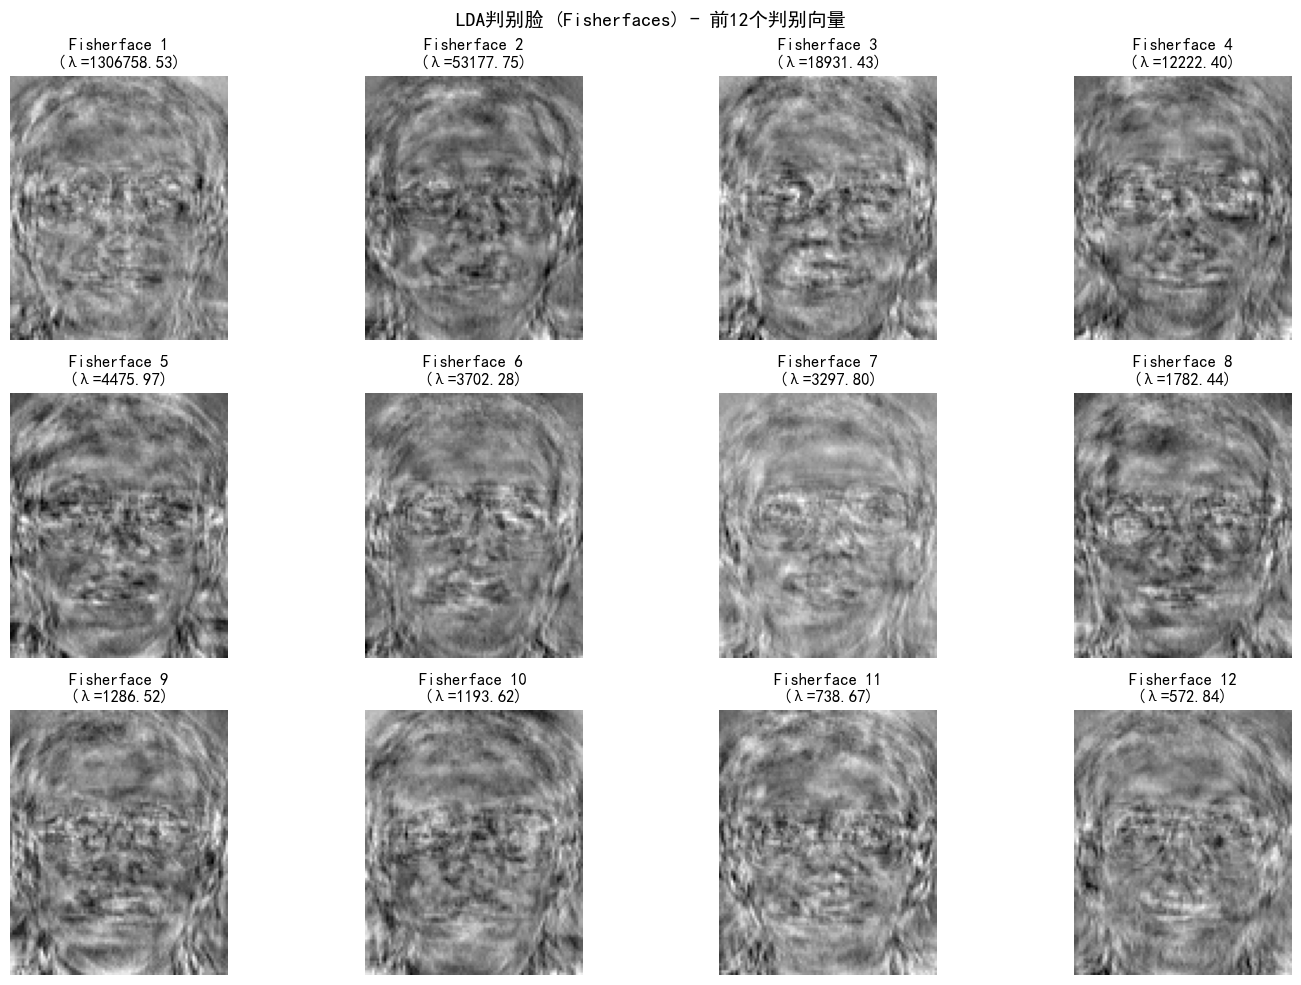

In [40]:
print("显示前12个Fisherface...")
print("Fisherface是LDA判别向量在原始图像空间中的表现")
print("每个Fisherface代表一个最优的类别判别方向\n")

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    fisherface = lda_clf.components[:, i].reshape(h, w)
    # 归一化显示
    fisherface_norm = (fisherface - fisherface.min()) / (fisherface.max() - fisherface.min())
    ax.imshow(fisherface_norm, cmap='gray')
    ax.set_title(f"Fisherface {i+1}\n(λ={lda_clf.explained_variance[i]:.2f})")
    ax.axis('off')
plt.suptitle('LDA判别脸 (Fisherfaces) - 前12个判别向量', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


绘制LDA特征值分析...
特征值λ表示对应判别向量的判别能力
特征值越大，该方向的类间区分能力越强



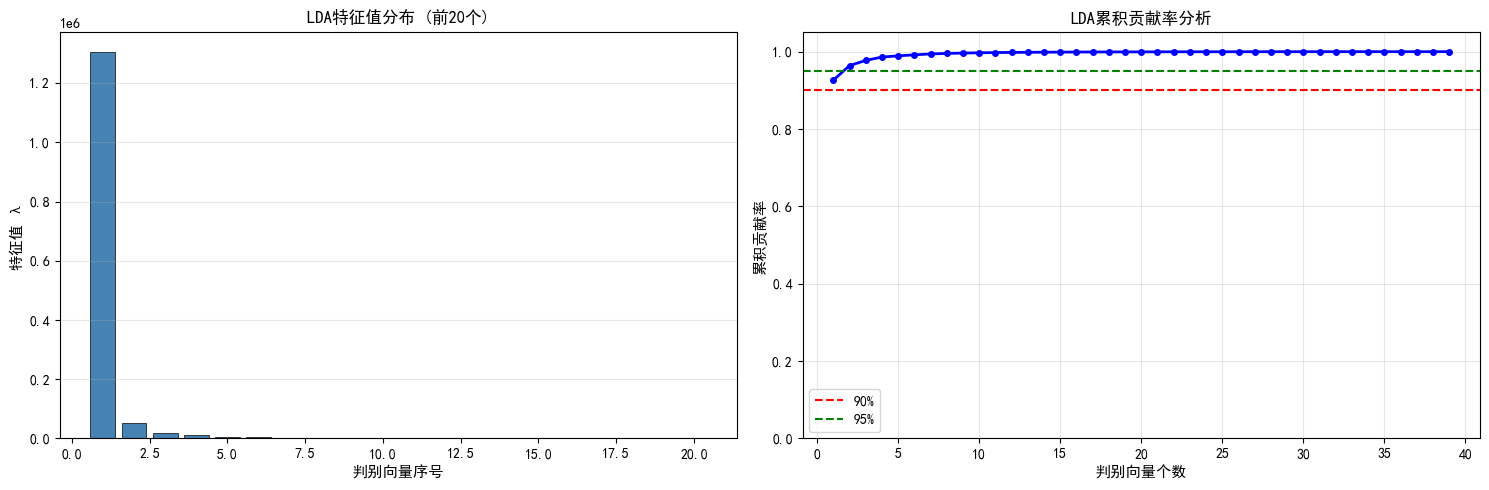


特征值统计：
   最大特征值: 1306758.527104
   前5个特征值: [1306758.52710435   53177.75321533   18931.43202121   12222.39821879
    4475.96577102]
   有效特征值个数 (>1e-10): 39
   前5个判别向量贡献率: 0.989162
   前10个判别向量贡献率: 0.997145
   所有判别向量贡献率: 1.000000
   理论最大判别向量数: 39


In [41]:
print("\n绘制LDA特征值分析...")
print("特征值λ表示对应判别向量的判别能力")
print("特征值越大，该方向的类间区分能力越强\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 显示前20个特征值的分布
num_show = min(20, len(lda_clf.explained_variance))
ax1.bar(range(1, num_show+1), 
        lda_clf.explained_variance[:num_show], 
        color='steelblue', edgecolor='black', linewidth=0.5)
ax1.set_xlabel('判别向量序号', fontsize=11, fontweight='bold')
ax1.set_ylabel('特征值 λ', fontsize=11, fontweight='bold')
ax1.set_title(f'LDA特征值分布 (前{num_show}个)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 累积贡献率
valid_eig = lda_clf.explained_variance[lda_clf.explained_variance > 1e-10]
if len(valid_eig) > 0:
    cumsum_var = np.cumsum(valid_eig) / np.sum(valid_eig)
    ax2.plot(range(1, len(cumsum_var)+1), cumsum_var, 'b-', linewidth=2, marker='o', markersize=4)
    ax2.axhline(y=0.9, color='r', linestyle='--', linewidth=1.5, label='90%')
    ax2.axhline(y=0.95, color='g', linestyle='--', linewidth=1.5, label='95%')
    ax2.set_xlabel('判别向量个数', fontsize=11, fontweight='bold')
    ax2.set_ylabel('累积贡献率', fontsize=11, fontweight='bold')
    ax2.set_title('LDA累积贡献率分析', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_ylim([0, 1.05])
else:
    ax2.text(0.5, 0.5, '所有特征值过小\n无法计算贡献率', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('LDA累积贡献率分析', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 特征值统计
print(f"\n特征值统计：")
print(f"   最大特征值: {lda_clf.explained_variance[0]:.6f}")
print(f"   前5个特征值: {lda_clf.explained_variance[:5]}")
if len(valid_eig) > 0:
    print(f"   有效特征值个数 (>1e-10): {len(valid_eig)}")
    if len(valid_eig) >= 5:
        print(f"   前5个判别向量贡献率: {cumsum_var[4]:.6f}")
    if len(valid_eig) >= 10:
        print(f"   前10个判别向量贡献率: {cumsum_var[9]:.6f}")
    print(f"   所有判别向量贡献率: {cumsum_var[-1]:.6f}")
print(f"   理论最大判别向量数: {len(np.unique(y_train)) - 1}")

In [42]:
print("\n实验总结与对比分析")
print("="*70)
print("\n**LDA (Fisherface) 特性总结：**")
print(f"   算法类型: 有监督降维")
print(f"   最大判别向量数: {len(np.unique(y_train)) - 1} (类别数-1)")
print(f"   实际使用判别向量数: {lda_clf.num_components}")
print(f"   特征值范围: [{lda_clf.explained_variance[-1]:.2e}, {lda_clf.explained_variance[0]:.2e}]")
print(f"   训练时间: {lda_clf.train_time:.4f} 秒")
print(f"   测试准确率: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\n**LDA相比PCA的优势：**")
print(f"   1. 利用类标签信息：有监督学习，针对分类任务优化")
print(f"   2. 更强的判别能力：最大化类间距/类内距比值")
print(f"   3. 维度约束更合理：最多c-1个判别方向，避免过拟合")
print(f"   4. 分类性能更好：专为分类任务设计的投影空间")

print(f"\n**算法核心思想：**")
print(f"   目标函数: J(w) = (w^T S_b w) / (w^T S_w w)")
print(f"   其中 S_b: 类间散度矩阵, S_w: 类内散度矩阵")
print(f"   求解: S_w^(-1) S_b w = λw (广义特征值问题)")
print(f"   结果: 找到最优的类别判别方向")

print(f"\n**实验结论：**")
if accuracy >= 0.95:
    print(f"   LDA在ORL人脸数据集上表现优秀，准确率达到{accuracy*100:.2f}%")
elif accuracy >= 0.90:
    print(f"   LDA在ORL人脸数据集上表现良好，准确率为{accuracy*100:.2f}%")
else:
    print(f"   LDA在ORL人脸数据集上表现一般，准确率为{accuracy*100:.2f}%")

print(f"   通过有监督降维，LDA能够有效地提取类别判别信息")
print(f"   在人脸识别任务中，Fisherface方法具有良好的判别能力")
print("="*70)


实验总结与对比分析

**LDA (Fisherface) 特性总结：**
   算法类型: 有监督降维
   最大判别向量数: 39 (类别数-1)
   实际使用判别向量数: 39
   特征值范围: [6.58e+00, 1.31e+06]
   训练时间: 0.9281 秒
   测试准确率: 0.9500 (95.00%)

**LDA相比PCA的优势：**
   1. 利用类标签信息：有监督学习，针对分类任务优化
   2. 更强的判别能力：最大化类间距/类内距比值
   3. 维度约束更合理：最多c-1个判别方向，避免过拟合
   4. 分类性能更好：专为分类任务设计的投影空间

**算法核心思想：**
   目标函数: J(w) = (w^T S_b w) / (w^T S_w w)
   其中 S_b: 类间散度矩阵, S_w: 类内散度矩阵
   求解: S_w^(-1) S_b w = λw (广义特征值问题)
   结果: 找到最优的类别判别方向

**实验结论：**
   LDA在ORL人脸数据集上表现优秀，准确率达到95.00%
   通过有监督降维，LDA能够有效地提取类别判别信息
   在人脸识别任务中，Fisherface方法具有良好的判别能力
